In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#models
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import EvalPrediction
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

#metrics
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from scipy.stats import mode

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## Task 1 - Corpus

In [51]:
def load_and_merge_data():
    
    #encodng the data into pandas.DataFrame objects
    url_a_test = '/kaggle/input/dataset/arguments-test.tsv'
    df_a_test = pd.read_csv(url_a_test, sep='\t')

    url_a_training = '/kaggle/input/dataset/arguments-training.tsv'
    df_a_training = pd.read_csv(url_a_training, sep='\t')

    url_a_validation = '/kaggle/input/dataset/arguments-validation.tsv'
    df_a_validation = pd.read_csv(url_a_validation, sep='\t')

    url_l_test = '/kaggle/input/dataset/labels-test.tsv'
    df_l_test = pd.read_csv(url_l_test, sep='\t')

    url_l_training = '/kaggle/input/dataset/labels-training.tsv'
    df_l_training = pd.read_csv(url_l_training, sep='\t')

    url_l_validation = '/kaggle/input/dataset/labels-validation.tsv'
    df_l_validation = pd.read_csv(url_l_validation, sep='\t')

    #merge argument dataframes with label dataframes
    df_test = pd.merge(df_a_test, df_l_test, on='Argument ID')
    df_training = pd.merge(df_a_training, df_l_training, on='Argument ID')
    df_validation = pd.merge(df_a_validation, df_l_validation, on='Argument ID')

    return df_test, df_training, df_validation

In [52]:
df_test, df_training, df_validation = load_and_merge_data()

In [53]:
def merge_and_drop_columns(df):
    # Merge level 2 annotations to level 3 categories
    df['Openess to change'] = df[['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism']].any(axis=1).astype(int)
    df['Self-enhancement'] = df[['Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face']].any(axis=1).astype(int)
    df['Conservation'] = df[['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility']].any(axis=1).astype(int)
    df['Self-transcendence'] = df[['Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']].any(axis=1).astype(int)
    
    # Drop unuseful columns
    columns_to_drop = ['Argument ID', 'Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']
    df = df.drop(columns=columns_to_drop)
    
    return df

df_test = merge_and_drop_columns(df_test)
df_training = merge_and_drop_columns(df_training)
df_validation = merge_and_drop_columns(df_validation)


In [54]:
df_test.head()

,Conclusion,Stance,Premise,Openess to change,Self-enhancement,Conservation,Self-transcendence
0,We should end affirmative action,against,affirmative action helps with employment equity.,0,1,1,1
1,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,0,1,0,1
2,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,0,1,1,1
3,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,0,1,0,0
4,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,0,1,1,1


### DATA EXPLORATION

Distribution of 'Conclusion' column length in the three datasets: the vast majority of the rows have len < 100.

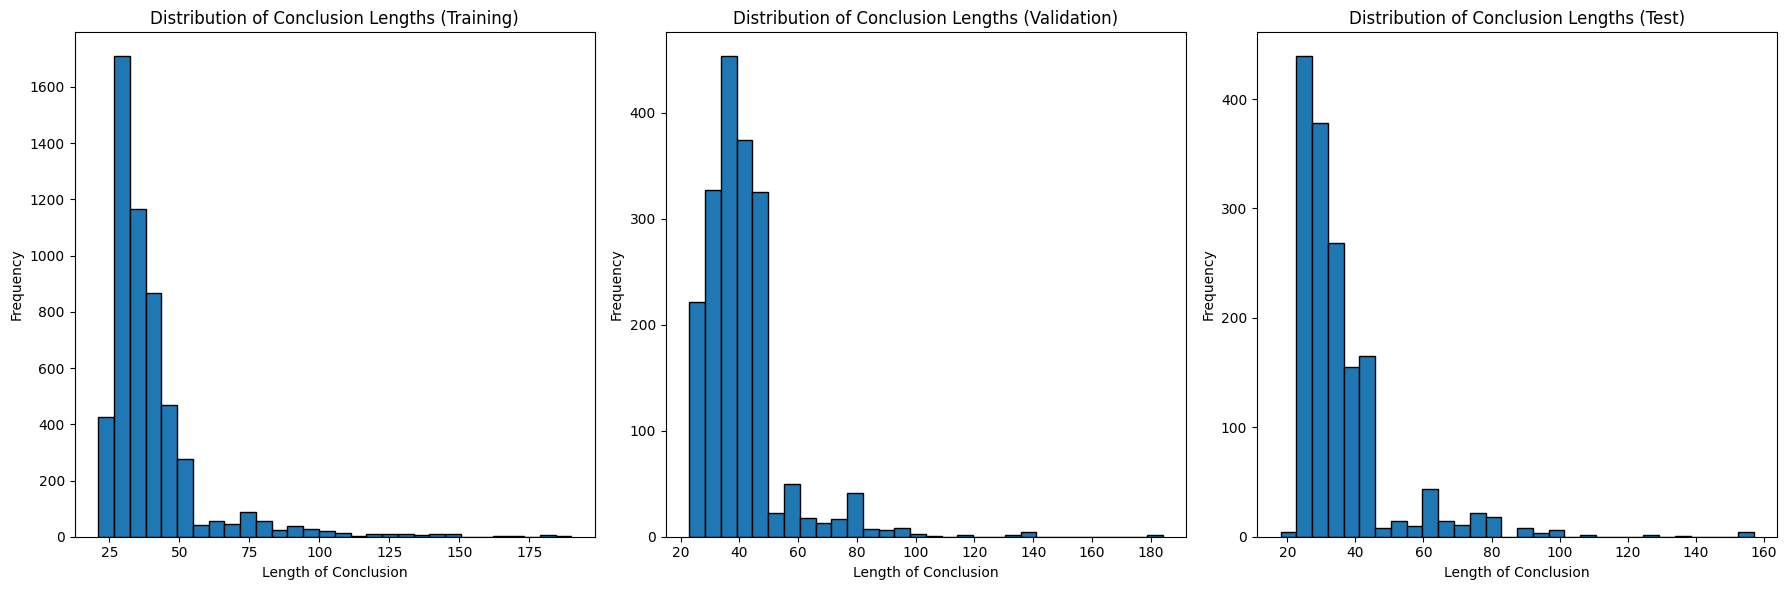

In [55]:
df_training['Conclusion_Length'] = df_training['Conclusion'].apply(len)
df_validation['Conclusion_Length'] = df_validation['Conclusion'].apply(len)
df_test['Conclusion_Length'] = df_test['Conclusion'].apply(len)

# Plot the distribution of the lengths for each DataFrame
plt.figure(figsize=(18, 6))

# Plot for df_training
plt.subplot(1, 3, 1)
plt.hist(df_training['Conclusion_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Conclusion Lengths (Training)')
plt.xlabel('Length of Conclusion')
plt.ylabel('Frequency')

# Plot for df_validation
plt.subplot(1, 3, 2)
plt.hist(df_validation['Conclusion_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Conclusion Lengths (Validation)')
plt.xlabel('Length of Conclusion')
plt.ylabel('Frequency')

# Plot for df_test
plt.subplot(1, 3, 3)
plt.hist(df_test['Conclusion_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Conclusion Lengths (Test)')
plt.xlabel('Length of Conclusion')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Distribution of 'Premise' column length in the three datasets.

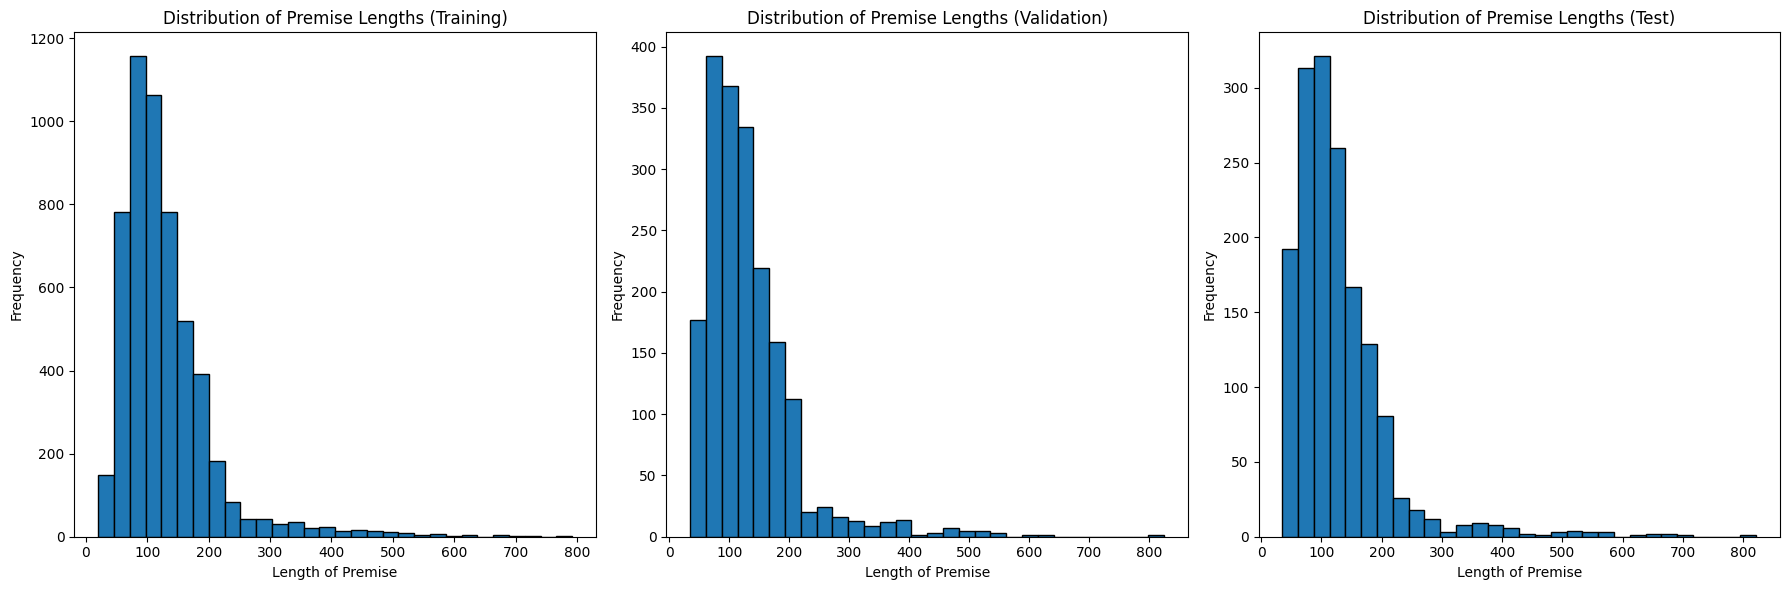

In [56]:
df_training['Premise_Length'] = df_training['Premise'].apply(len)
df_validation['Premise_Length'] = df_validation['Premise'].apply(len)
df_test['Premise_Length'] = df_test['Premise'].apply(len)

# Plot the distribution of the lengths for each DataFrame
plt.figure(figsize=(18, 6))

# Plot for df_training
plt.subplot(1, 3, 1)
plt.hist(df_training['Premise_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Premise Lengths (Training)')
plt.xlabel('Length of Premise')
plt.ylabel('Frequency')

# Plot for df_validation
plt.subplot(1, 3, 2)
plt.hist(df_validation['Premise_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Premise Lengths (Validation)')
plt.xlabel('Length of Premise')
plt.ylabel('Frequency')

# Plot for df_test
plt.subplot(1, 3, 3)
plt.hist(df_test['Premise_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Premise Lengths (Test)')
plt.xlabel('Length of Premise')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Distribution of 'Stance' column: only two values appear in in this column. This observation justifies the numerical encoding of this column into 1 and 0.

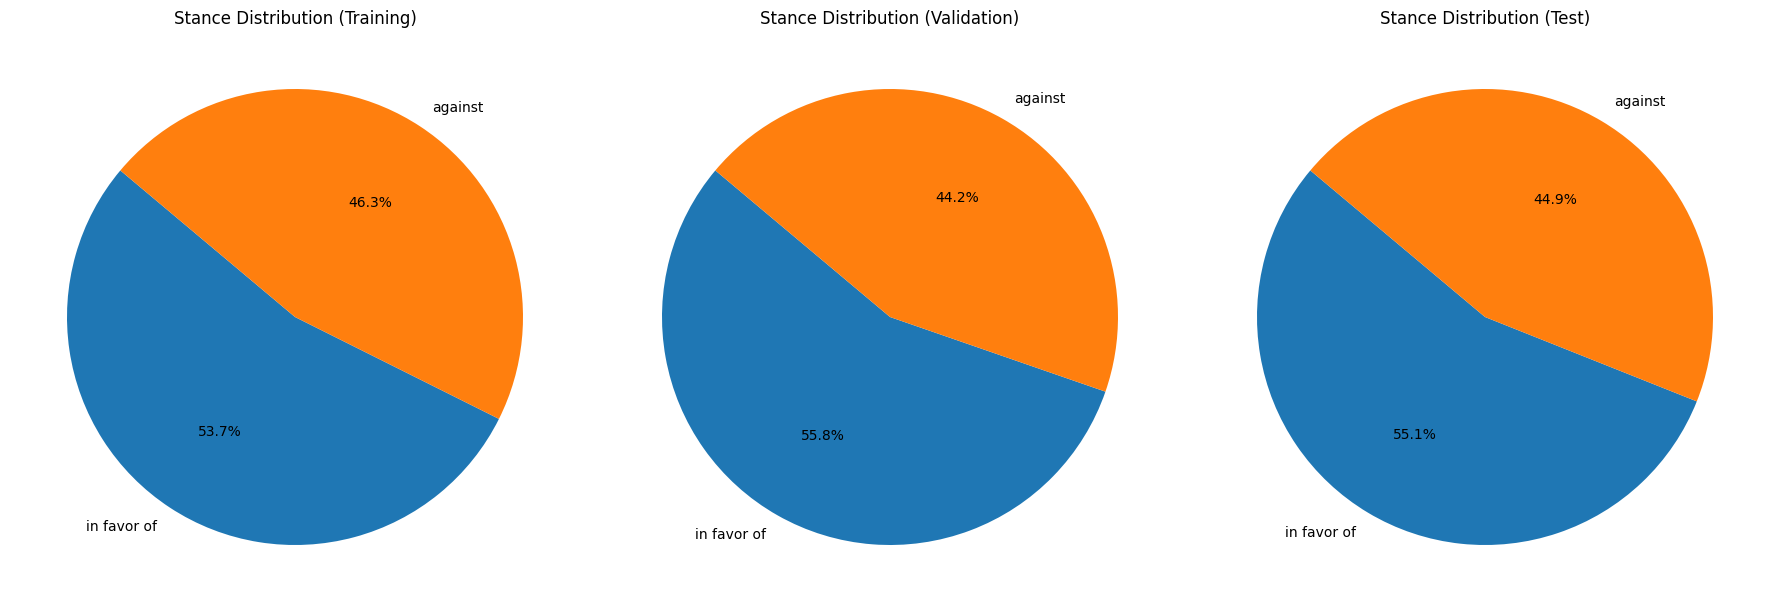

In [57]:
# Calculate the distribution of the 'Stance' column
stance_distribution_training = df_training['Stance'].value_counts()
stance_distribution_validation = df_validation['Stance'].value_counts()
stance_distribution_test = df_test['Stance'].value_counts()

# Plot the pie charts
plt.figure(figsize=(18, 6))

# Pie chart for df_training
plt.subplot(1, 3, 1)
plt.pie(stance_distribution_training, labels=stance_distribution_training.index, autopct='%1.1f%%', startangle=140)
plt.title('Stance Distribution (Training)')

# Pie chart for df_validation
plt.subplot(1, 3, 2)
plt.pie(stance_distribution_validation, labels=stance_distribution_validation.index, autopct='%1.1f%%', startangle=140)
plt.title('Stance Distribution (Validation)')

# Pie chart for df_test
plt.subplot(1, 3, 3)
plt.pie(stance_distribution_test, labels=stance_distribution_test.index, autopct='%1.1f%%', startangle=140)
plt.title('Stance Distribution (Test)')

plt.tight_layout()
plt.show()

Distribution of the four categories in the datasets.

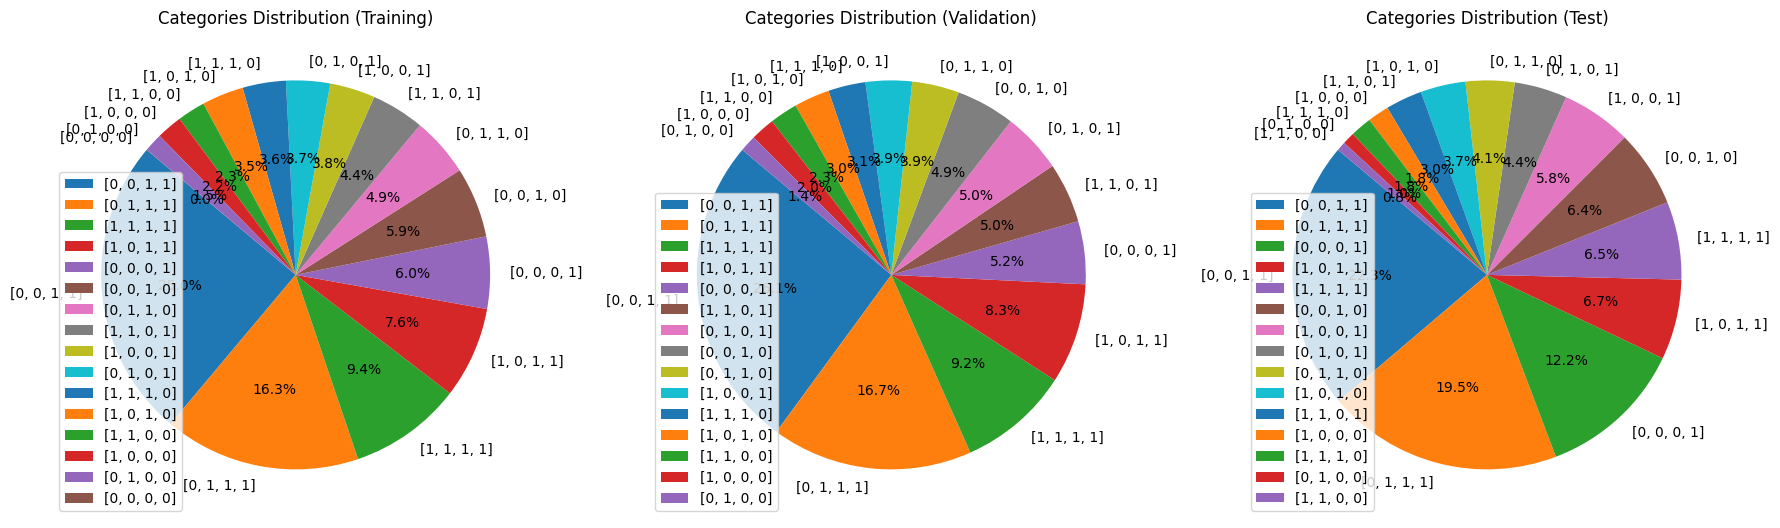

In [58]:
# Define a new column containing the vector of the four specified columns
df_training['Values_Vector'] = df_training[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].values.tolist()
df_validation['Values_Vector'] = df_validation[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].values.tolist()
df_test['Values_Vector'] = df_test[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].values.tolist()

# Calculate the distribution of the 'Stance' column
labels_distribution_training = df_training['Values_Vector'].value_counts()
labels_distribution_validation = df_validation['Values_Vector'].value_counts()
labels_distribution_test = df_test['Values_Vector'].value_counts()

# Plot the pie charts
plt.figure(figsize=(18, 6))

# Pie chart for df_training
plt.subplot(1, 3, 1)
patches, texts, autotexts = plt.pie(labels_distribution_training, labels=labels_distribution_training.index, autopct='%1.1f%%', startangle=140)
plt.title('Categories Distribution (Training)')
plt.legend(patches, labels_distribution_training.index, loc="best")

# Pie chart for df_validation
plt.subplot(1, 3, 2)
patches, texts, autotexts = plt.pie(labels_distribution_validation, labels=labels_distribution_validation.index, autopct='%1.1f%%', startangle=140)
plt.title('Categories Distribution (Validation)')
plt.legend(patches, labels_distribution_validation.index, loc="best")

# Pie chart for df_test
plt.subplot(1, 3, 3)
patches, texts, autotexts = plt.pie(labels_distribution_test, labels=labels_distribution_test.index, autopct='%1.1f%%', startangle=140)
plt.title('Categories Distribution (Test)')
plt.legend(patches, labels_distribution_test.index, loc="best")

plt.tight_layout()
plt.show()

### DATA PREPROCESSING

Encoding 'Stance' column into numerical format  

In [59]:
df_test['Stance'] = df_test['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)
df_training['Stance'] = df_training['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)
df_validation['Stance'] = df_validation['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)

/tmp/ipykernel_34/2140913224.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Stance'] = df_test['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)
/tmp/ipykernel_34/2140913224.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_training['Stance'] = df_training['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)
/tmp/ipykernel_34/2140913224.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call

Preparing data for tokenization input

In [60]:
labels_test = df_test.iloc[:, 3:7].values
labels_training = df_training.iloc[:, 3:7].values
labels_validation = df_validation.iloc[:, 3:7].values

stance_test = df_test['Stance'].values
stance_training = df_training['Stance'].values
stance_validation = df_validation['Stance'].values

Tokenization process and creation of a dataset structure compatible with the bert model 

In [61]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_length = 100

class BertDatasetCreator(Dataset):
    def __init__(self, encodings, labels, tokenizer, max_length):
        self.encodings = encodings
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.encodings)
    
    def __getitem__(self, idx):
        item = str(self.encodings[idx])
        item = ' '.join(item.split())
        
        encoded_dict = self.tokenizer.encode_plus(
            item,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
        )
        input_ids = encoded_dict['input_ids']
        attention_masks = encoded_dict['attention_mask']
        token_type_ids = encoded_dict['token_type_ids']

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_masks, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

#### Applying the BertDatasetCreator and preparing the datasets for the three different type of BERT models

##### BERT w/C dataset

In [62]:
test_dataset_c = BertDatasetCreator(df_test['Conclusion'], labels_test, tokenizer, max_length)
train_dataset_c = BertDatasetCreator(df_training['Conclusion'], labels_training, tokenizer, max_length)
val_dataset_c = BertDatasetCreator(df_validation['Conclusion'], labels_validation, tokenizer, max_length)

DataLoader definition - which will supply the data to the neural network in batches for efficient training and processing

In [63]:
batch_size = 16
test_dataloader_c = DataLoader(test_dataset_c, batch_size=batch_size)
train_dataloader_c = DataLoader(train_dataset_c, batch_size=batch_size)
val_dataloader_c = DataLoader(val_dataset_c, batch_size=batch_size)

##### BERT w/CP

In [64]:
test_dataset_cp = BertDatasetCreator(df_test['Conclusion'] + ' ' + df_test['Premise'], labels_test, tokenizer, max_length)
train_dataset_cp = BertDatasetCreator(df_training['Conclusion'] + ' ' + df_training['Premise'], labels_training, tokenizer, max_length)
val_dataset_cp = BertDatasetCreator(df_validation['Conclusion'] + ' ' + df_validation['Premise'], labels_validation, tokenizer, max_length)

test_dataloader_cp = DataLoader(test_dataset_cp, batch_size=batch_size)
train_dataloader_cp = DataLoader(train_dataset_cp, batch_size=batch_size)
val_dataloader_cp = DataLoader(val_dataset_cp, batch_size=batch_size)

##### BERT w/CPS

In [65]:
test_dataset_cps = BertDatasetCreator(df_test['Conclusion'] + ' ' + df_test['Premise'] + ' ' + df_test['Stance'], labels_test, tokenizer, max_length)
train_dataset_cps = BertDatasetCreator(df_training['Conclusion'] + ' ' + df_training['Premise'] + ' ' + df_training['Stance'], labels_training, tokenizer, max_length)
val_dataset_cps = BertDatasetCreator(df_validation['Conclusion'] + ' ' + df_validation['Premise'] + ' ' + df_validation['Stance'], labels_validation, tokenizer, max_length)

test_dataloader_cps = DataLoader(test_dataset_cps, batch_size=batch_size)
train_dataloader_cps = DataLoader(train_dataset_cps, batch_size=batch_size)
val_dataloader_cps = DataLoader(val_dataset_cps, batch_size=batch_size)

## Task 2 - Models Definitions

### BASELINE MODELS

Random uniform classifier

In [66]:
def create_random_uniform_classifier(label):
    def random_uniform_classifier(size):
        return np.random.choice([0, 1], size=size)
    return random_uniform_classifier

Majority classifier - always predicting the most frequent valorization for the column

In [67]:
def create_majority_classifier(label, train_data):
    # Calcola il majority_value come la moda della colonna corrispondente alla label nel dataset di train
    majority_value = train_data[label].mode()[0]
    def majority_classifier(size):
        return np.full(size, majority_value)
    return majority_classifier

Creating the baseline models for every category and saving them in a classifiers dictionary

In [68]:
classifiers = {}

labels = ['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']

#create classifiers for each category and save them in the dictionary
for label in labels:
    #random uniform classifier
    random_uniform_name = f'random_uniform_classifier_{label}'
    classifiers[random_uniform_name] = create_random_uniform_classifier(label)

    #majority classifier
    majority_name = f'majority_classifier_{label}'
    classifiers[majority_name] = create_majority_classifier(label, df_training)

### BERT Model Definition

In [69]:
class Bert_Model(torch.nn.Module):
    def __init__(self):
        super(Bert_Model, self).__init__()
        self.bert = AutoModel.from_pretrained(
            pretrained_model_name_or_path= 'bert-base-uncased', 
            problem_type='multi_label_classification', 
            num_labels = 4, 
            return_dict=False)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, 4)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs

#### Bert Models

In [70]:
c_model = Bert_Model()
cp_model = Bert_Model()
cps_model = Bert_Model()

c_model.to(device)
cp_model.to(device)
cps_model.to(device)

Bert_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

## Task 3 - Metrics

### Baseline models metrics function

In [71]:
def baseline_metrics(predicted_results, test_dataset, labels):
    f1_scores = {}
    binary_f1_scores = []
    for label in labels:
        true_values = test_dataset[label]
        predictions = predicted_results[label]
        f1 = f1_score(true_values, predictions, average='binary')
        f1 = round(f1, 2) #round to 2 decimal places
        f1_score_name = f'{label}'
        f1_scores[f1_score_name] = f1

        #binary f1 score for every category
        binary_f1 = f1_score(true_values, predictions, average='binary')
        binary_f1_scores.append(binary_f1)

     #macro f1 score
    macro_f1 = round(np.mean(binary_f1_scores), 2)
    f1_scores['Macro F1'] = macro_f1
    return f1_scores

Baseline models metrics printing function

In [72]:
def print_baseline_metrics(metrics, type):
    if type == 'random_uniform':
        classifier_type = 'Random Uniform'
    elif type == 'majority':
        classifier_type = 'Majority'
    print(f"Classifier Type: {classifier_type}")
    for label, score in metrics.items():
        print(f"{label}: {score}")

### BERT models metrics function

In [73]:
def generate_classification_report(model, X_test, Y_test, thresholds):
    
    # Mettere il modello in modalità di valutazione
    model.eval()
    Y_pred = []
    num_labels = len(thresholds)
    return_report = {}
    precision_recall_data = {str(i): {'precision': [], 'recall': []} for i in range(num_labels)}

    with torch.no_grad():# Disabilitare il calcolo dei gradienti per la valutazione
        for _, batch in enumerate(X_test, 0):
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            
            # Spostare il tensore degli output sulla CPU e convertirlo in un array NumPy
            outputs = outputs.cpu().numpy()

        # Applica le soglie ottimali per ottenere le previsioni binarie
            preds = np.zeros_like(outputs)
            for i in range(num_labels):
                preds[:, i] = (outputs[:, i] > thresholds[i]).astype(int)
            Y_pred.extend(preds)
            
    Y_pred = np.array(Y_pred)
    
    # Generare il classification report
    report = classification_report(Y_test, Y_pred, zero_division=1, output_dict=True)
    conf_matrix = multilabel_confusion_matrix(Y_test, Y_pred)
    
    # Estrazione di precision e recall
    for label, metrics in report.items():
        if label not in ['accuracy', 'micro avg', 'macro avg', 'samples avg', 'weighted avg']:
            precision_recall_data[label]['precision'] = metrics['precision']
            precision_recall_data[label]['recall'] = metrics['recall']
    
    # Mappatura delle labels
    label_names = {
        '0': "Openess to change",
        '1': "Self-enhancement",
        '2': "Conservation",
        '3': "Self-transcendence"
    }
    
    # Estrarre e stampare l'F1 score per ogni etichetta
    print("\nF1 Scores per Label:")
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            label_name = label_names.get(label, f"Label {label}")
            f1_score = metrics['f1-score']
            print(f"{label_name} F1: = {f1_score:.2f}")
            return_report[label_name] = f1_score
    
    # Estrarre e stampare il macro F1 score
    macro_f1_score = report['macro avg']['f1-score']
    print(f"Macro F1 Score: {macro_f1_score:.2f}")
    return_report['Macro F1'] = macro_f1_score
    
    return return_report, precision_recall_data, conf_matrix

Defining a dictionary to store all the classification reports - one for each model per seed. 

In [74]:
classification_reports = {}
precision_recall = {}
confusion_matrixes = {}

## Task 4 - Training and evaluation

### Baseline models training and metrics

### Random uniform classifiers

In [75]:
def random_uniform_classifiers(classifiers, test_dataset, labels):
    predicted_results = {}

    for label in labels:
        random_uniform_name = f'random_uniform_classifier_{label}'
        classifier = classifiers[random_uniform_name]
        test_data = test_dataset[label]
        size = len(test_data)
        predictions = classifier(size)
        predicted_results[label] = predictions

    return predicted_results

In [76]:
metrics_random_uniform = baseline_metrics(random_uniform_classifiers(classifiers, df_test, labels), df_test, labels)
print_baseline_metrics(metrics_random_uniform, 'random_uniform')
classification_reports['classification_report_baseline_model_random'] = metrics_random_uniform

Classifier Type: Random Uniform
Openess to change: 0.36
Self-enhancement: 0.48
Conservation: 0.6
Self-transcendence: 0.63
Macro F1: 0.52


### Majority classifiers

In [77]:
def majority_classifiers(classifiers, test_dataset, labels):
    predicted_results = {}

    for label in labels:
        majority_name = f'majority_classifier_{label}'
        classifier = classifiers[majority_name]
        test_data = test_dataset[label]
        size = len(test_data)
        predictions = classifier(size)
        predicted_results[label] = predictions

    return predicted_results

Metrics for the majority classifiers - F1 score for each category and macro F1 score 

In [78]:
metrics_majority = baseline_metrics(majority_classifiers(classifiers, df_test, labels), df_test, labels)
print_baseline_metrics(metrics_majority, 'majority')
classification_reports['classification_report_baseline_model_majority'] = metrics_majority

Classifier Type: Majority
Openess to change: 0.0
Self-enhancement: 0.0
Conservation: 0.83
Self-transcendence: 0.89
Macro F1: 0.43


### BERT model training and evaluation

Training process utils

In [79]:
#definition of the loss function
def loss_function(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

#definition of the optimizers
c_optimizer = Adam(c_model.parameters(), lr = 1e-5)
cp_optimizer = Adam(cp_model.parameters(), lr = 1e-5)
cps_optimizer = Adam(cps_model.parameters(), lr = 1e-5)

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

seeds = [22, 157, 2024]
epochs = 5

#### Training function definition

In [80]:
def trainBert(model, dataloader, optimizer, loss_function):
    model.train()
    running_loss = 0.0
    for _, data in enumerate(dataloader, 0):
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        labels = data['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)
    
        loss_value = loss_function(outputs, labels)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        avg_train_loss = running_loss / len(dataloader)
    
    return avg_train_loss

#### Validation function definition

In [81]:
def validate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader, 0):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    # Numero di etichette
    num_labels = all_labels.shape[1]

    # Inizializza una lista per memorizzare le soglie ottimali per ogni etichetta
    optimal_thresholds = []
    auc_scores = []

    for i in range(num_labels):
        # Calcola la curva ROC
        fpr, tpr, thresholds = roc_curve(all_labels[:, i], all_outputs[:, i])
        # Calcola l'AUC
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        # Trova la soglia che massimizza la somma di sensibilità e specificità
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)

    # Applica le soglie ottimali per ottenere le previsioni binarie
    all_preds = np.zeros_like(all_outputs)
    for i in range(num_labels):
        all_preds[:, i] = (all_outputs[:, i] > optimal_thresholds[i]).astype(int)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1, optimal_thresholds


### Training and evaluating BERT w/C

Training, evaluation and metrics 

In [82]:
for seed in seeds:
    set_seed(seed)
    print(f'\nSeed {seed}\n-------------------------------')
    for epoch in range(epochs):
        #training
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        avg_train_loss = trainBert(c_model, train_dataloader_c, c_optimizer, loss_function)
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        #validation
        accuracy, precision, recall, f1, c_thresholds = validate_model(c_model, val_dataloader_c)
        print(f'Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    #generate classification-report
    print(f'\nClassification report \n-------------------------------')
    classification_report_name = f'classification_report_c_model_{seed}'
    precision_recall_name = f'c_model_{seed}'
    confusion_matrix_name = f'c_model_{seed}'

    classification_reports[classification_report_name], precision_recall_data, confusion_matrix = generate_classification_report(c_model, test_dataloader_c, labels_test, c_thresholds)
    precision_recall[precision_recall_name] = [precision_recall_data]
    confusion_matrixes[confusion_matrix_name] = confusion_matrix
    
    torch.save(c_model.state_dict(), f'c_model_{seed}.pth')


Seed 22
-------------------------------

Epoch 1
-------------------------------
Average Train Loss: 0.6035
Validation - Accuracy: 0.2031, Precision: 0.7231, Recall: 0.6540, F1 Score: 0.6849

Epoch 2
-------------------------------
Average Train Loss: 0.5639
Validation - Accuracy: 0.1973, Precision: 0.7455, Recall: 0.6361, F1 Score: 0.6744

Epoch 3
-------------------------------
Average Train Loss: 0.5502
Validation - Accuracy: 0.1851, Precision: 0.7516, Recall: 0.5672, F1 Score: 0.6445

Epoch 4
-------------------------------
Average Train Loss: 0.5435
Validation - Accuracy: 0.2009, Precision: 0.7554, Recall: 0.5504, F1 Score: 0.6270

Epoch 5
-------------------------------
Average Train Loss: 0.5404
Validation - Accuracy: 0.2036, Precision: 0.7549, Recall: 0.5993, F1 Score: 0.6626

Classification report 
-------------------------------

F1 Scores per Label:
Openess to change F1: = 0.38
Self-enhancement F1: = 0.47
Conservation F1: = 0.57
Self-transcendence F1: = 0.66
Label micro avg

### Training and evaluating BERT w/CP

Training, evaluation and metrics 

In [83]:
for seed in seeds:
    set_seed(seed)
    print(f'\nSeed {seed}\n-------------------------------')
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        avg_train_loss = trainBert(cp_model, train_dataloader_cp, cp_optimizer, loss_function)
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        #validation
        accuracy, precision, recall, f1, cp_thresholds = validate_model(cp_model, val_dataloader_cp)
        print(f'Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    #generate classification-report
    print(f'\nClassification report \n-------------------------------')
    classification_report_name = f'classification_report_cp_model_{seed}'
    precision_recall_name = f'cp_model_{seed}'
    confusion_matrix_name = f'cp_model_{seed}'
    
    classification_reports[classification_report_name], precision_recall_data, confusion_matrix = generate_classification_report(cp_model, test_dataloader_cp, labels_test, cp_thresholds)
    precision_recall[precision_recall_name] = [precision_recall_data]
    confusion_matrixes[confusion_matrix_name] = confusion_matrix
    
    torch.save(cp_model.state_dict(), f'cp_model_{seed}.pth')


Seed 22
-------------------------------

Epoch 1
-------------------------------
Average Train Loss: 0.5851
Validation - Accuracy: 0.2505, Precision: 0.7589, Recall: 0.7570, F1 Score: 0.7524

Epoch 2
-------------------------------
Average Train Loss: 0.5032
Validation - Accuracy: 0.2743, Precision: 0.7947, Recall: 0.7141, F1 Score: 0.7519

Epoch 3
-------------------------------
Average Train Loss: 0.4475
Validation - Accuracy: 0.2732, Precision: 0.8022, Recall: 0.7059, F1 Score: 0.7498

Epoch 4
-------------------------------
Average Train Loss: 0.3909
Validation - Accuracy: 0.2052, Precision: 0.8093, Recall: 0.6529, F1 Score: 0.7124

Epoch 5
-------------------------------
Average Train Loss: 0.3327
Validation - Accuracy: 0.2405, Precision: 0.8137, Recall: 0.6583, F1 Score: 0.7249

Classification report 
-------------------------------

F1 Scores per Label:
Openess to change F1: = 0.57
Self-enhancement F1: = 0.63
Conservation F1: = 0.78
Self-transcendence F1: = 0.77
Label micro avg

### Training and evaluating BERT w/CPS

Training, evaluation and metrics 

In [84]:
for seed in seeds:
    set_seed(seed)
    print(f'\nSeed {seed}\n-------------------------------')
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        avg_train_loss = trainBert(cps_model, train_dataloader_cps, cps_optimizer, loss_function)
        print(f'Loss: {avg_train_loss:.4f}')
        #validation
        accuracy, precision, recall, f1, cps_thresholds = validate_model(cps_model, val_dataloader_cps)
        print(f'Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    #generate classification-report
    print(f'\nClassification report \n-------------------------------')
    classification_report_name = f'classification_report_cps_model_{seed}'
    precision_recall_name = f'cps_model_{seed}'
    confusion_matrix_name = f'cps_model_{seed}'
    
    classification_reports[classification_report_name], precision_recall_data, confusion_matrix = generate_classification_report(cps_model, test_dataloader_cps, labels_test, cps_thresholds)
    precision_recall[precision_recall_name] = [precision_recall_data]
    confusion_matrixes[confusion_matrix_name] = confusion_matrix
    
    torch.save(cps_model.state_dict(), f'cps_model_{seed}.pth')


Seed 22
-------------------------------

Epoch 1
-------------------------------
Loss: 0.5831
Validation - Accuracy: 0.2210, Precision: 0.7704, Recall: 0.6917, F1 Score: 0.7220

Epoch 2
-------------------------------
Loss: 0.5099
Validation - Accuracy: 0.2426, Precision: 0.7901, Recall: 0.6848, F1 Score: 0.7285

Epoch 3
-------------------------------
Loss: 0.4558
Validation - Accuracy: 0.2210, Precision: 0.7923, Recall: 0.6793, F1 Score: 0.7247

Epoch 4
-------------------------------
Loss: 0.4013
Validation - Accuracy: 0.2389, Precision: 0.7983, Recall: 0.6844, F1 Score: 0.7291

Epoch 5
-------------------------------
Loss: 0.3402
Validation - Accuracy: 0.2231, Precision: 0.8243, Recall: 0.6348, F1 Score: 0.7122

Classification report 
-------------------------------

F1 Scores per Label:
Openess to change F1: = 0.56
Self-enhancement F1: = 0.58
Conservation F1: = 0.79
Self-transcendence F1: = 0.73
Label micro avg F1: = 0.70
Label samples avg F1: = 0.70
Macro F1 Score: 0.67

Seed 15

## Task 5 - Error Analysis

Compare F1 score for each models

In [85]:
# Creare un DataFrame a partire dal dizionario di dizionari
table = pd.DataFrame(classification_reports)
 
# Trasporre il DataFrame per avere le chiavi come righe
table = table.T
# Definire l'ordine desiderato delle righe
desired_order = ['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence', 'Macro F1']
 
# Raggruppare le colonne per seed
table['Seed'] = table.index.str.split('_').str[4]
table['Model'] = table.index.str.split('_').str[2]
table = table.pivot_table(index=['Model', 'Seed'])
table = table.T

# Utilizzare reindex per ordinare le righe
table = table.reindex(desired_order, level=1)
 
# Stampare la tabella con solo le etichette degli indici selezionate
print(table)

Model              baseline                c                            cp  \
Seed               majority random       157      2024        22       157   
Openess to change      0.00   0.36  0.057361  0.322051  0.377031  0.560901   
Self-enhancement       0.00   0.48  0.372659  0.594340  0.472318  0.630453   
Conservation           0.83   0.60  0.453473  0.416216  0.566911  0.780891   
Self-transcendence     0.89   0.63  0.709588  0.498584  0.663429  0.710640   
Macro F1               0.43   0.52  0.398270  0.457798  0.519922  0.670721   

Model                                        cps                      
Seed                    2024        22       157      2024        22  
Openess to change   0.556391  0.570539  0.559535  0.566816  0.555126  
Self-enhancement    0.645418  0.627148  0.647482  0.617221  0.584753  
Conservation        0.770608  0.782405  0.793151  0.794559  0.793381  
Self-transcendence  0.713611  0.770331  0.702909  0.754142  0.728972  
Macro F1            0.67150

Model performance on most/less frequent classes

In [86]:
# Identify the label with the most 1 values and the one with the most 0 values
most_1_label = df_test[labels].sum().idxmax()
most_0_label = df_test[labels].sum().idxmin()
 
print(f"Label with most 1 values: {most_1_label}")
print(f"Label with most 0 values: {most_0_label}")
 
# Creare un DataFrame a partire dal dizionario di dizionari
table_small = pd.DataFrame(classification_reports)
 
# Trasporre il DataFrame per avere le chiavi come righe
table_small = table_small.T
# Definire l'ordine desiderato delle righe
desired_order_small = [most_1_label, most_0_label]
 
# Raggruppare le colonne per seed
table_small['Seed'] = table_small.index.str.split('_').str[4]
table_small['Model'] = table_small.index.str.split('_').str[2]
table_small = table_small.pivot_table(index=['Model', 'Seed'])
table_small = table_small.T

# Utilizzare reindex per ordinare le righe
table_small = table_small.reindex(desired_order_small, level=1)
 
# Stampare la tabella con solo le etichette degli indici selezionate
print(table_small) 

Label with most 1 values: Self-transcendence
Label with most 0 values: Openess to change
Model              baseline                c                            cp  \
Seed               majority random       157      2024        22       157   
Self-transcendence     0.89   0.63  0.709588  0.498584  0.663429  0.710640   
Openess to change      0.00   0.36  0.057361  0.322051  0.377031  0.560901   

Model                                        cps                      
Seed                    2024        22       157      2024        22  
Self-transcendence  0.713611  0.770331  0.702909  0.754142  0.728972  
Openess to change   0.556391  0.570539  0.559535  0.566816  0.555126  


Plotting precision and recall curves for the three models

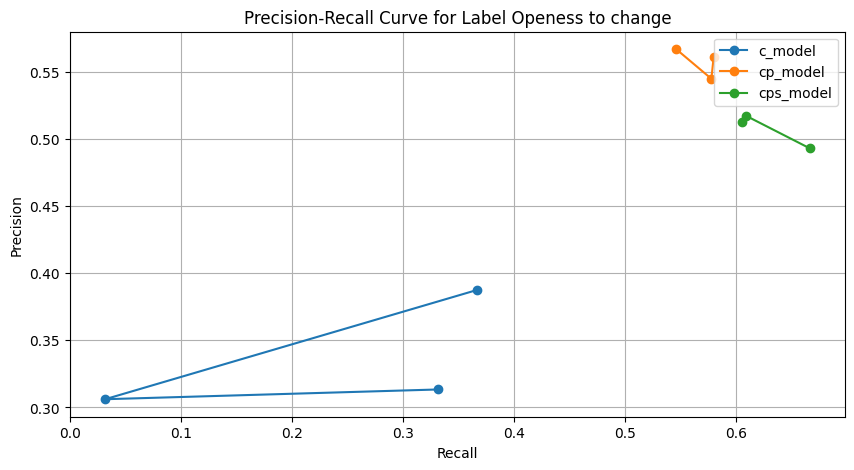

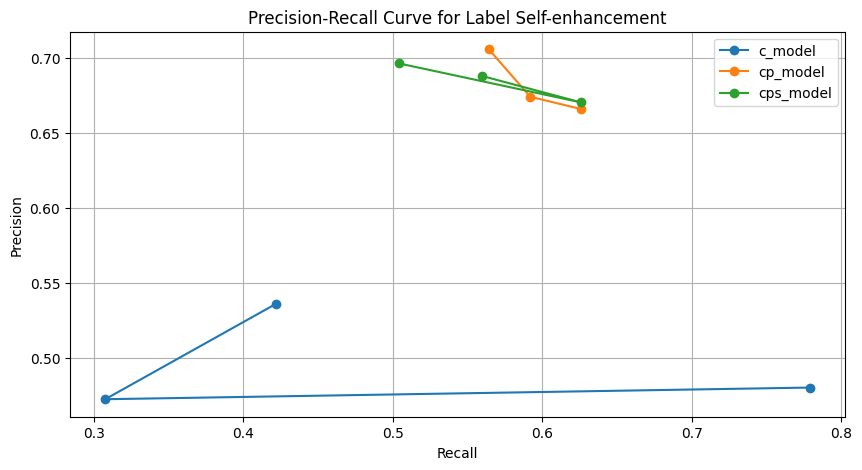

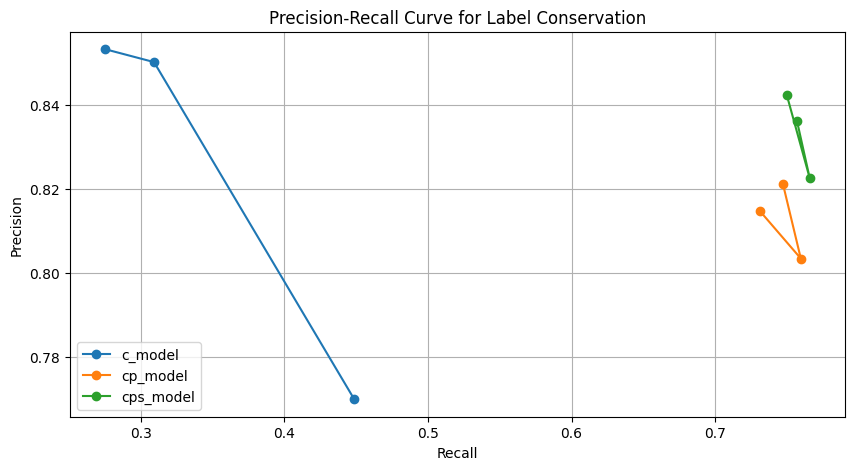

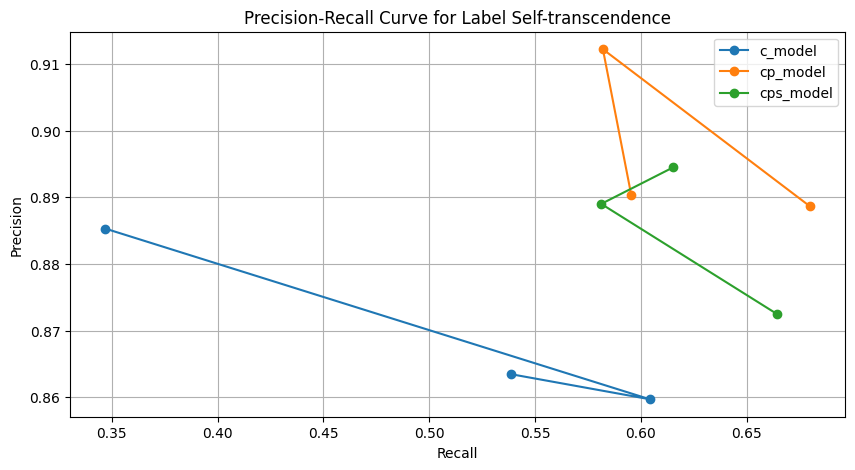

In [100]:
label_names = {
    '0': "Openess to change",
    '1': "Self-enhancement",
    '2': "Conservation",
    '3': "Self-transcendence"
    }

# Iterare attraverso le etichette
for label in ['0', '1', '2', '3']:
    plt.figure(figsize=(10, 5))
    for model_prefix in ['c_model', 'cp_model', 'cps_model']:
        precisions = []
        recalls = []
        #print(f"model prefix: {model_prefix}")
        for seed in ['22', '157', '2024']:
            model_name = f'{model_prefix}_{seed}'
            #print(f"modello con seed: {model_name}")
            if model_name in precision_recall:
                metrics = precision_recall[model_name][0]
                #print(metrics)
                if label in metrics:
                    precisions.append(metrics[label]['precision'])
                    recalls.append(metrics[label]['recall'])
        
        label_name = label_names.get(label, f"Label {label}")
        plt.plot(recalls, precisions, marker='o', label=f'{model_prefix}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Label {label_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

Displaying confuson matrices for the three models

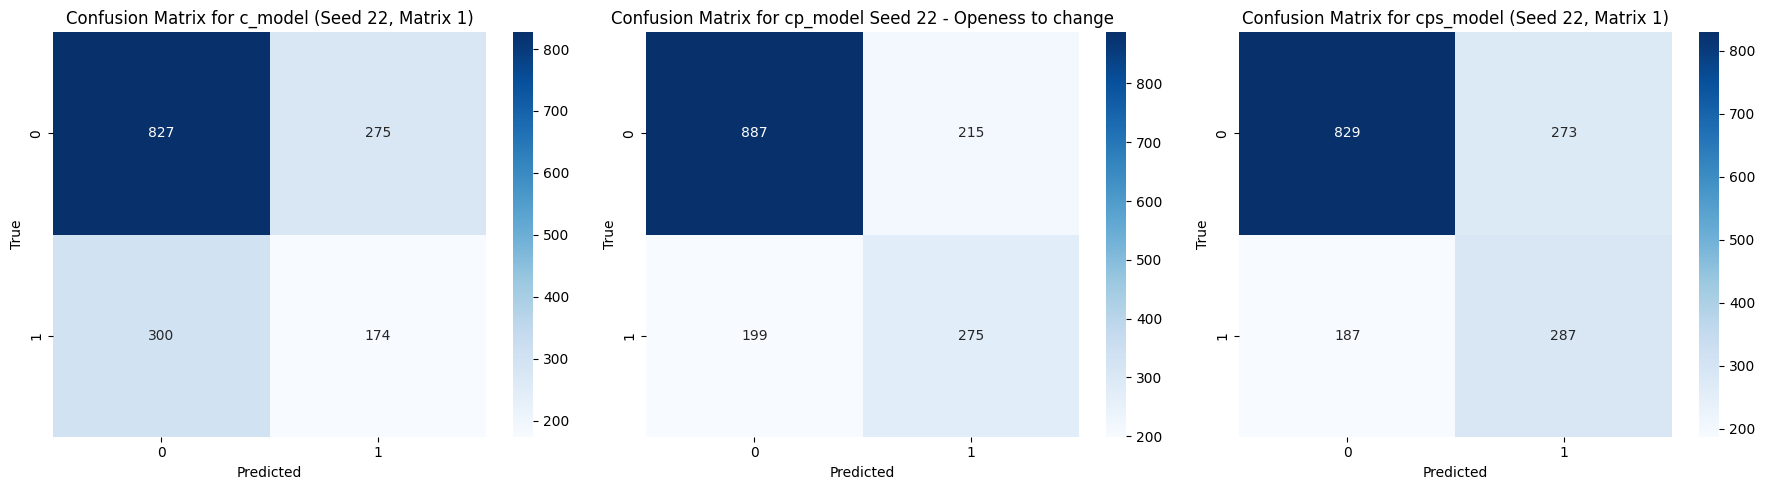

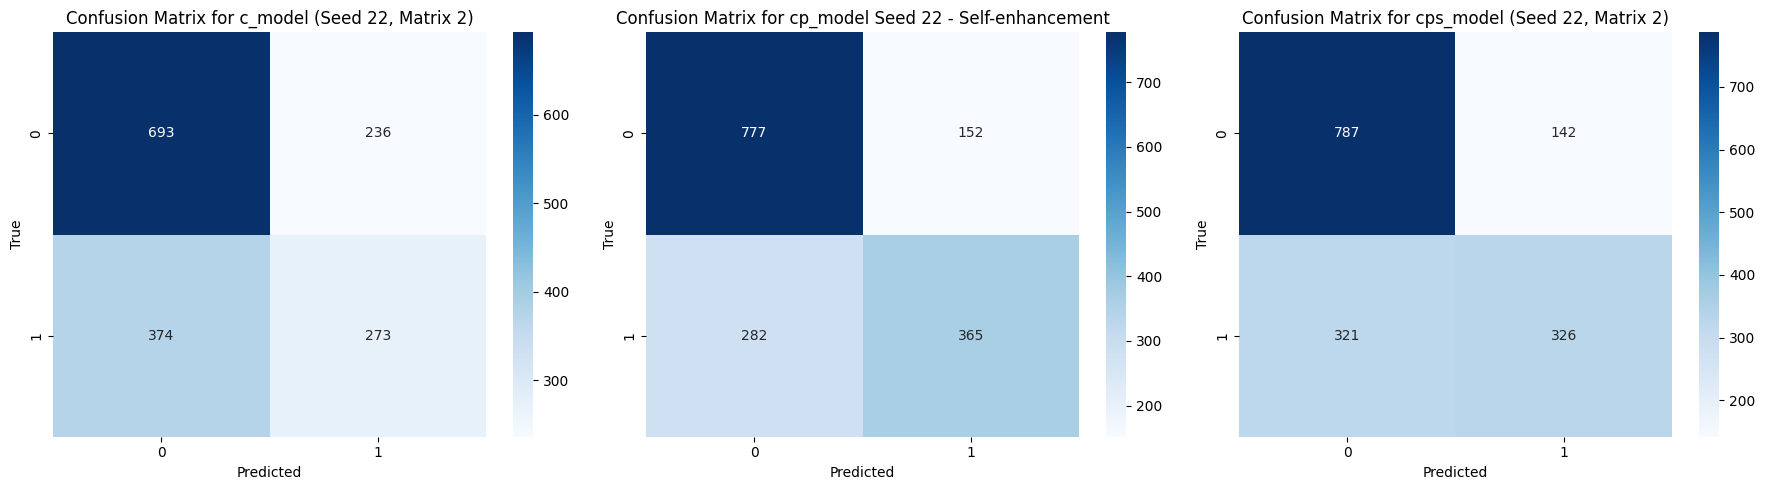

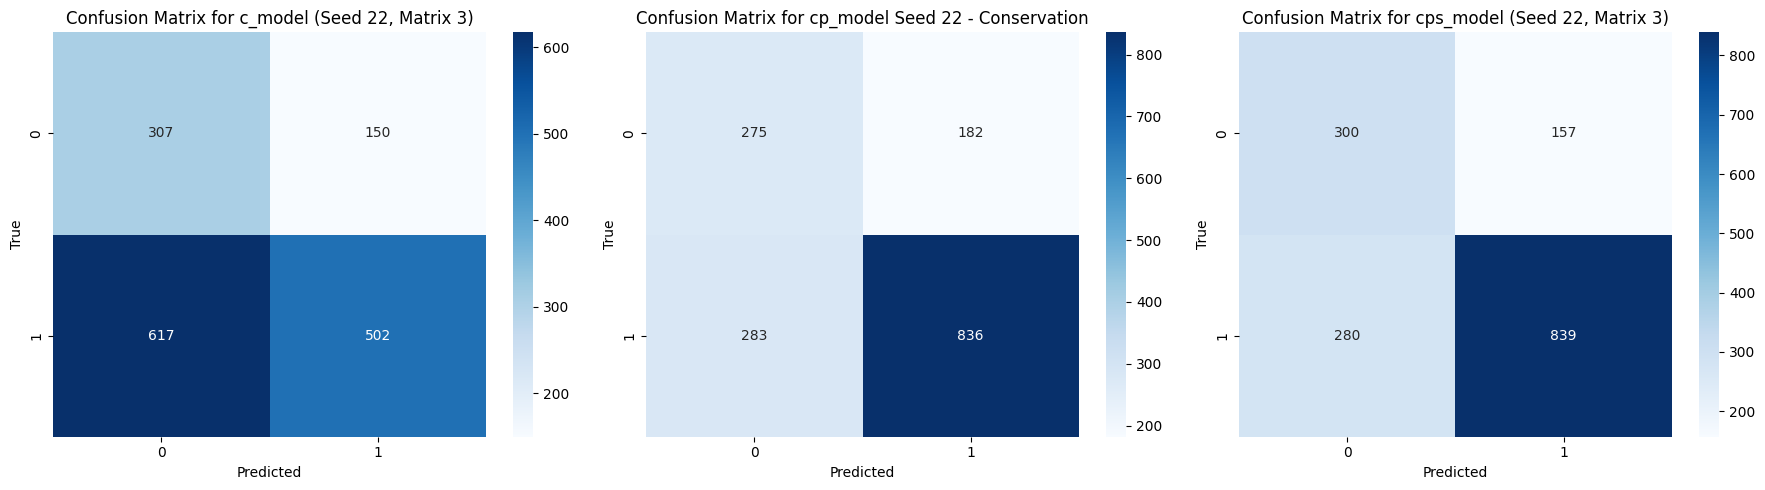

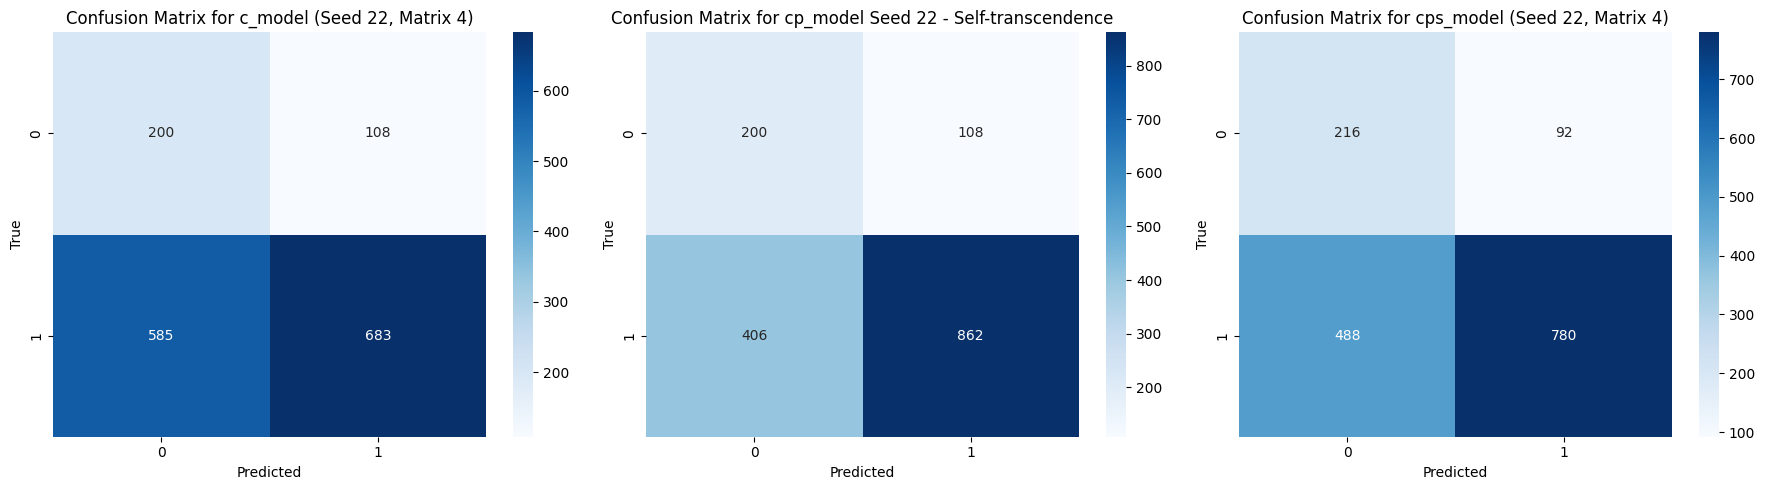

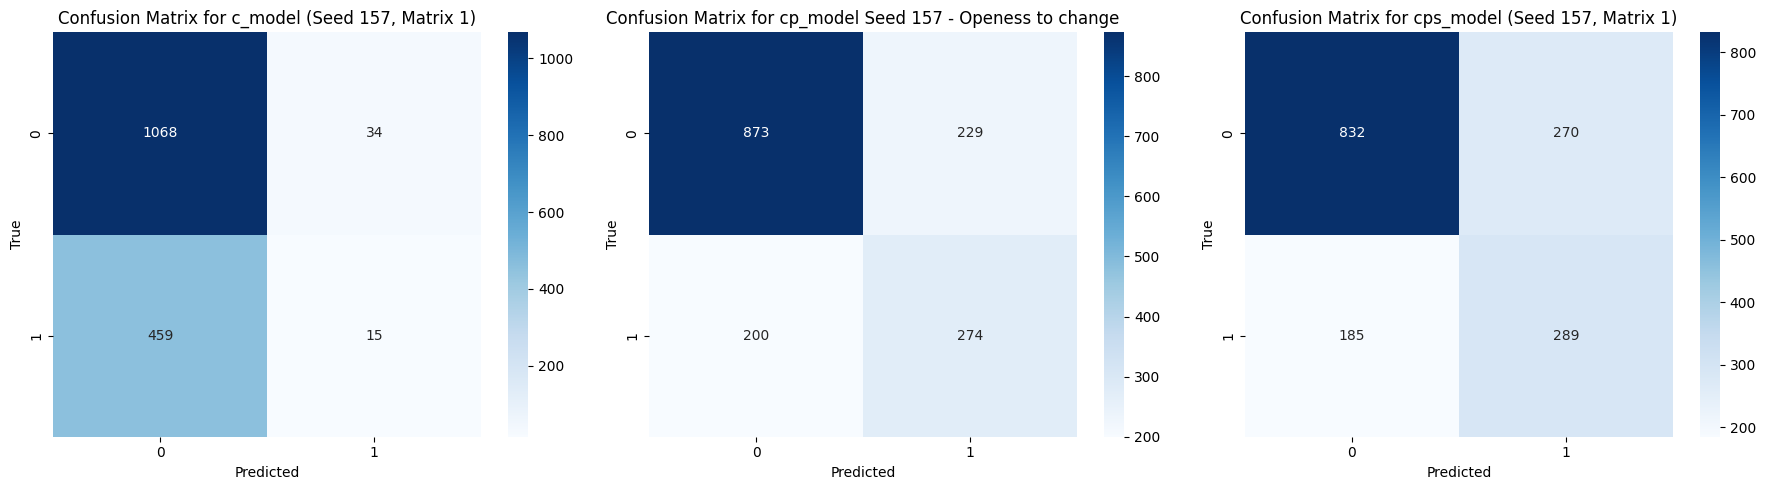

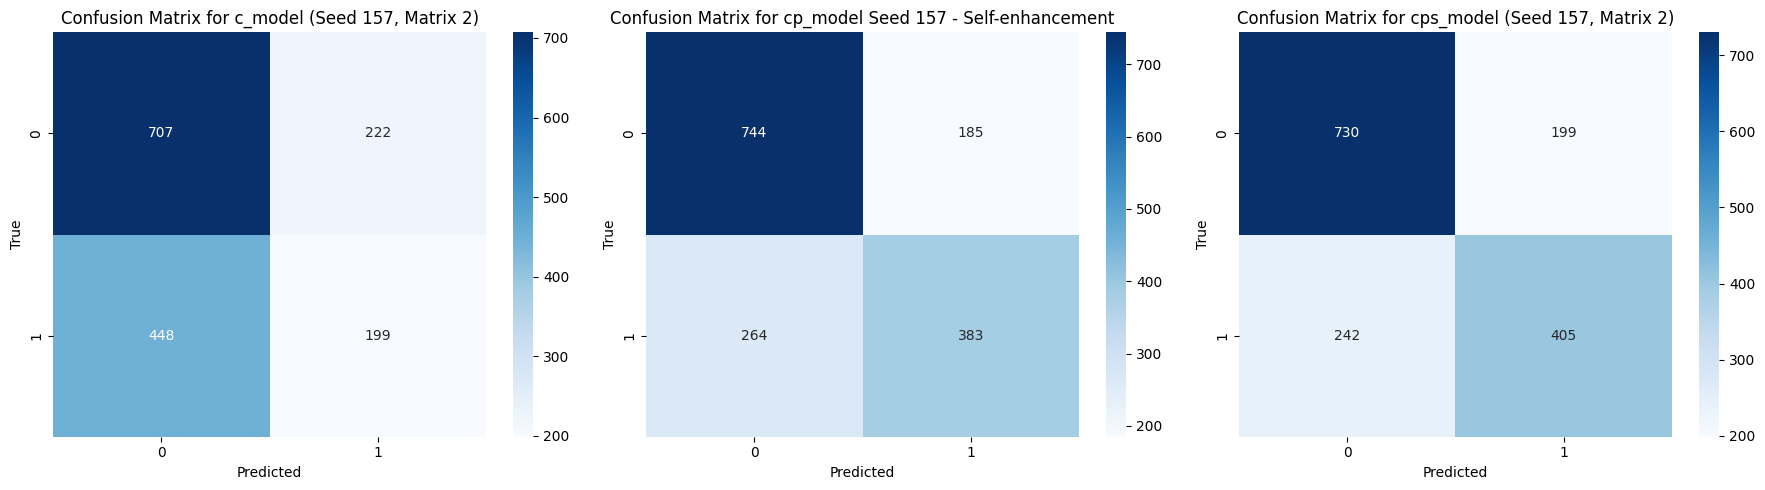

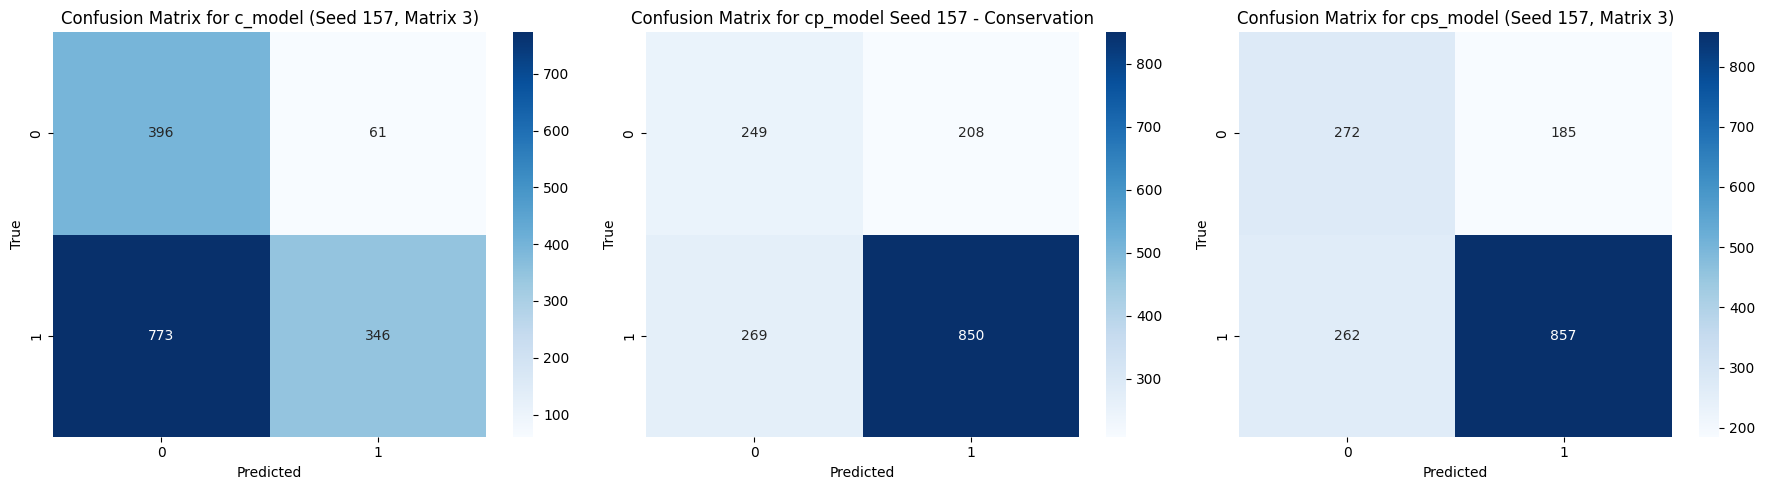

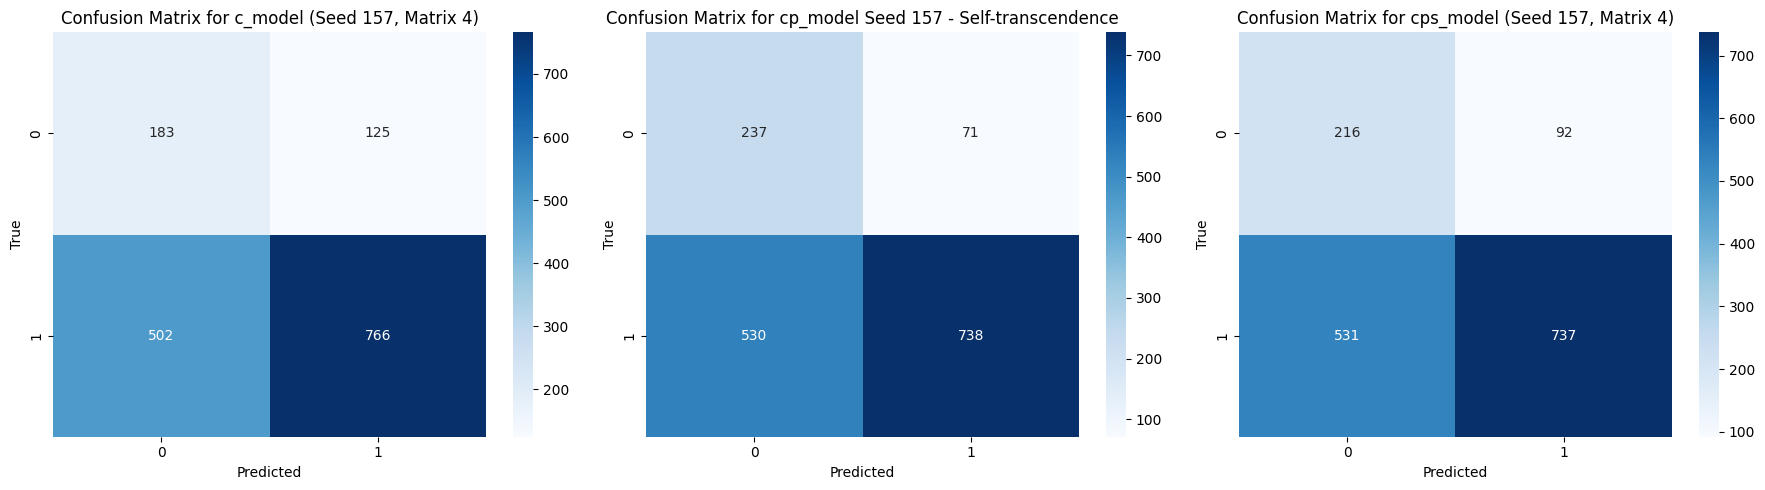

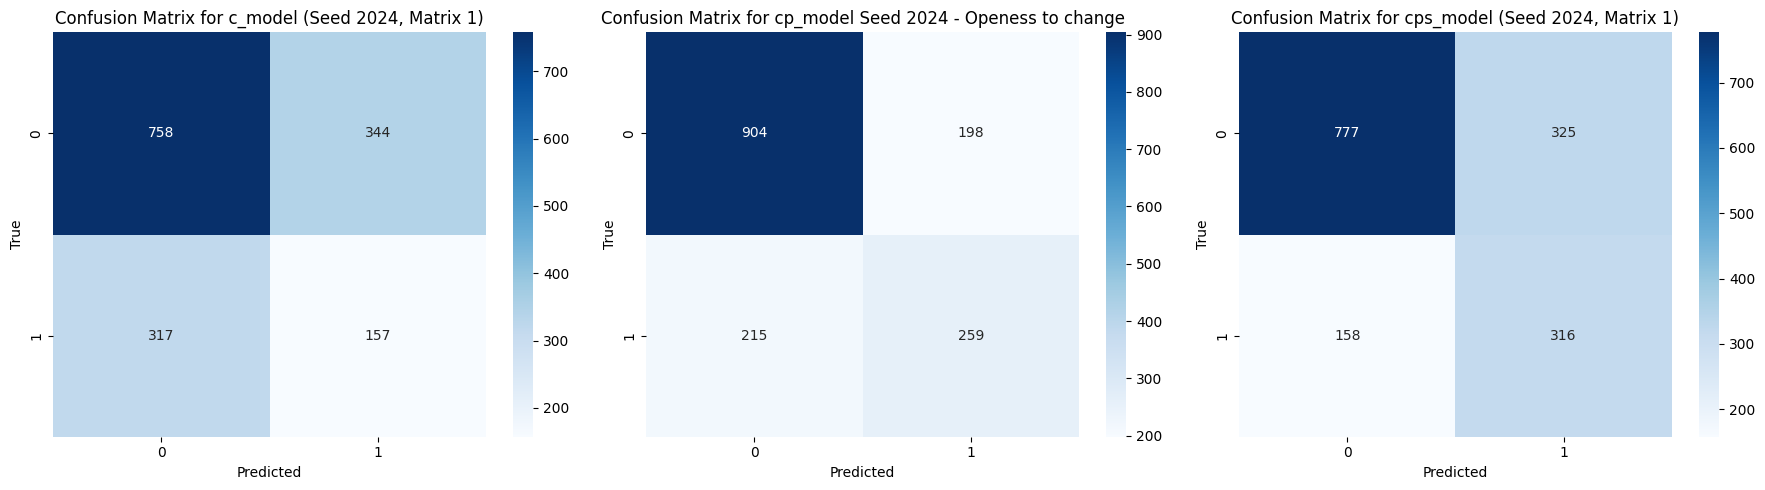

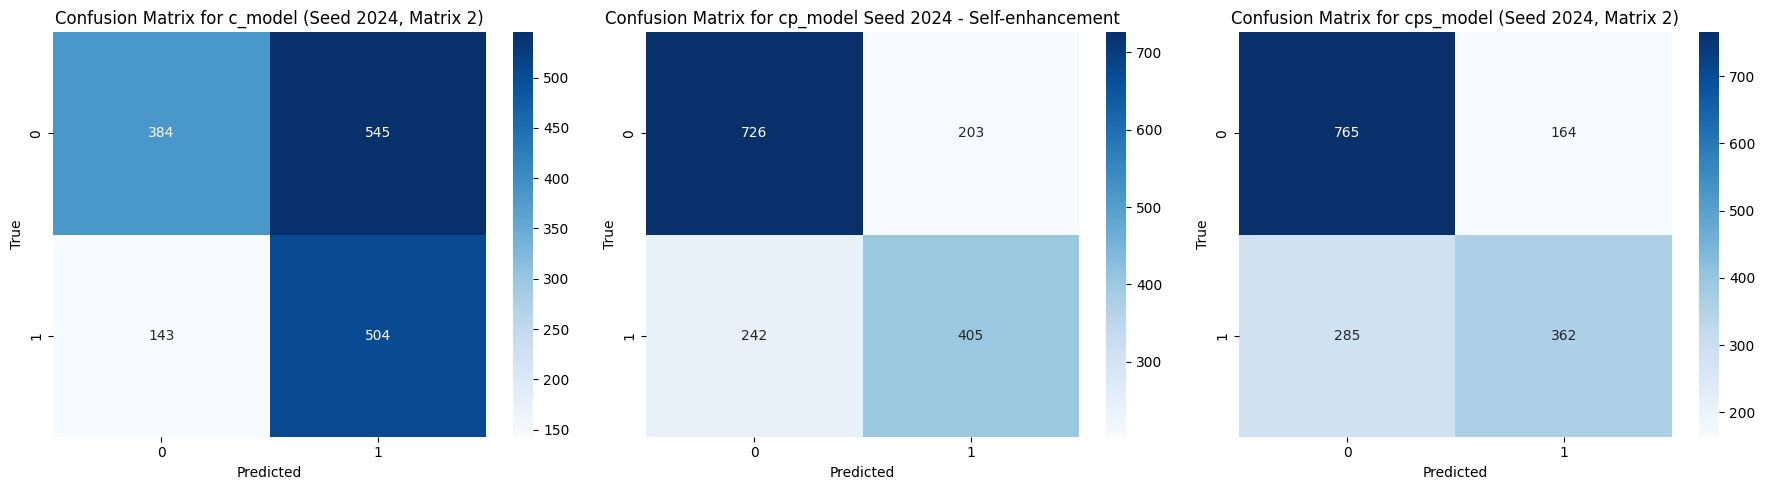

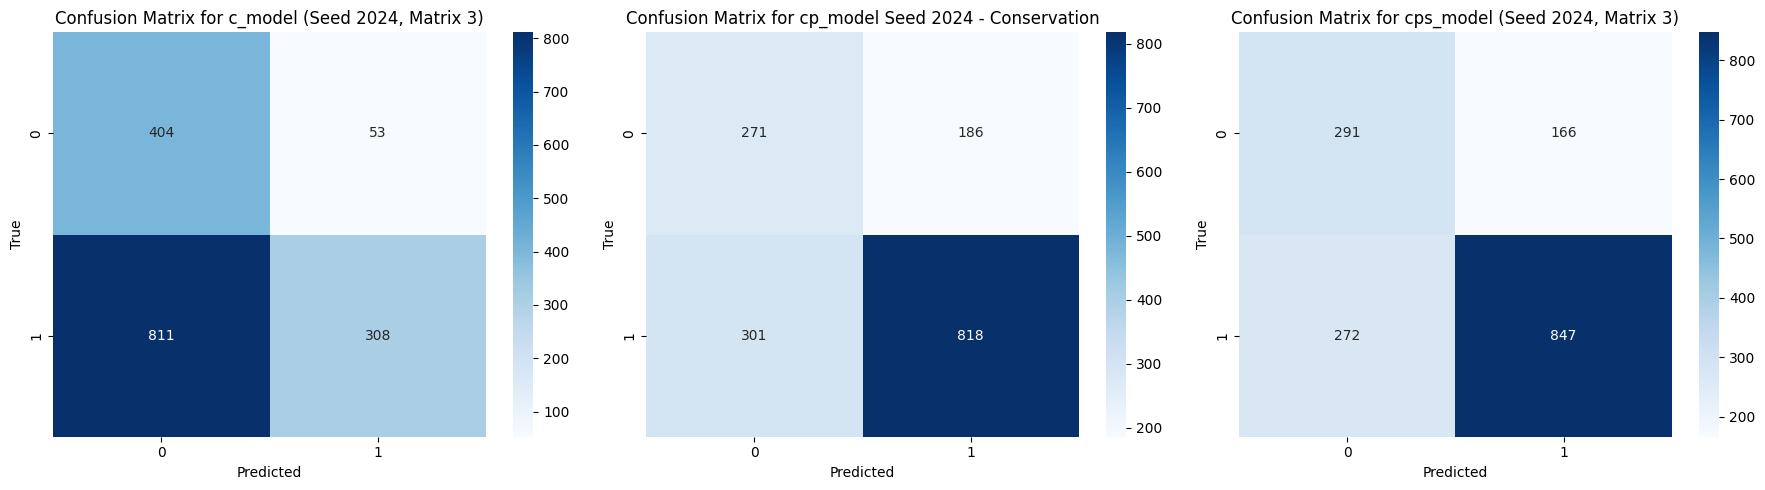

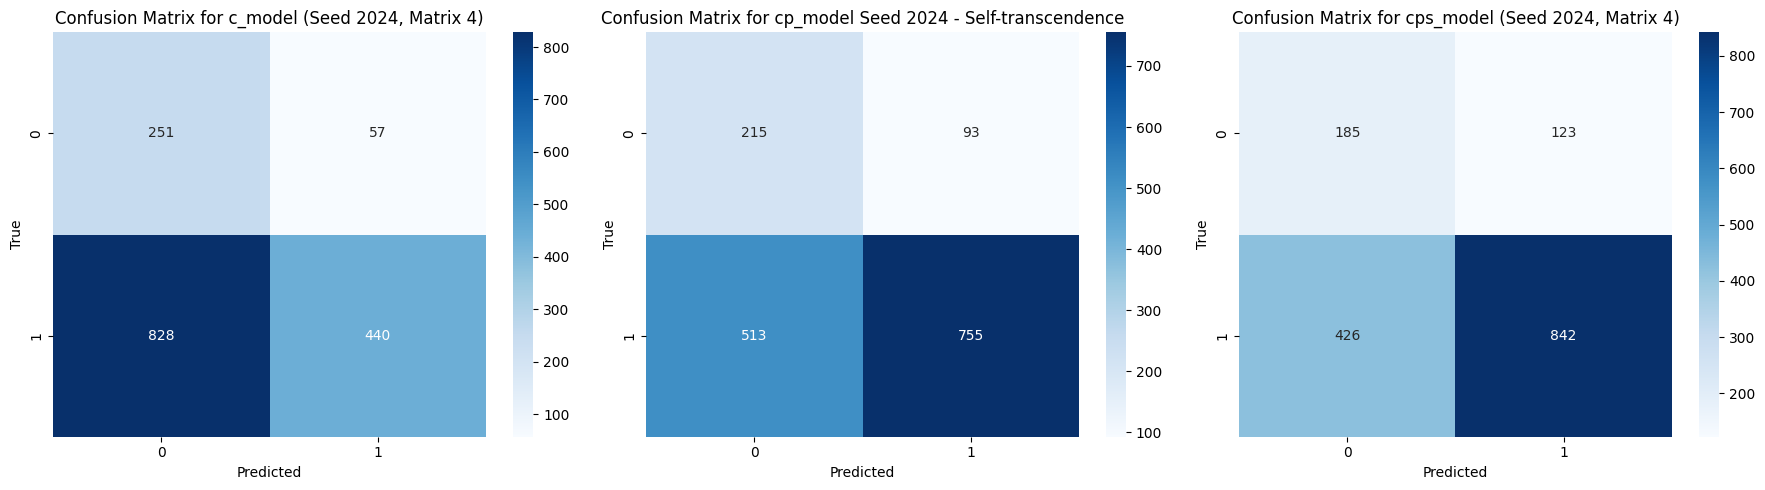

In [90]:
for seed in seeds:
    # Ottieni le matrici di confusione per ogni modello
    c_matrices = confusion_matrixes[f'c_model_{seed}']
    cp_matrices = confusion_matrixes[f'cp_model_{seed}']
    cps_matrices = confusion_matrixes[f'cps_model_{seed}']
    
    # Assicurati che il numero di matrici di confusione sia lo stesso per ogni modello
    num_matrices = len(c_matrices)
    
    for i in range(num_matrices):
        # Plot the confusion matrices
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        sns.heatmap(c_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title(f'Confusion Matrix for c_model (Seed {seed}, Matrix {i+1})')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        
        sns.heatmap(cp_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[1])
        axes[1].set_title(f'Confusion Matrix for cp_model Seed {seed} - {labels[i]}')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('True')
        
        sns.heatmap(cps_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[2])
        axes[2].set_title(f'Confusion Matrix for cps_model (Seed {seed}, Matrix {i+1})')
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('True')
        
        plt.tight_layout()
        plt.show()
        

Analyzing some misclassification examples

In [89]:
#ho bisogno di Y_pred per confrontarli con le true labels
#Y_pred potrei farmelo restituire da generate_classification_report ma non ho idea di che formato abbia siccome in input do il test_dataloader